In [11]:
%matplotlib inline

## Intro

Este tutorial é basedao nos tutoriais de [Pytorch](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) de mesmo nome.

## Dados

Baixe os dados [aqui](https://download.pytorch.org/tutorial/data.zip)

No diretório, existem 18 arquivos com nomes em várias línguas, um nome por língua (mas ainda é necesário converter os nomes do formato Unicode para ASCII)

Isto irá gerar um dicionário com um idioma e nomes comuns aquele idioma.

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(category_lines['Italian'][:5])

['data/names/Scottish.txt', 'data/names/Irish.txt', 'data/names/Polish.txt', 'data/names/Russian.txt', 'data/names/Portuguese.txt', 'data/names/Czech.txt', 'data/names/Vietnamese.txt', 'data/names/Korean.txt', 'data/names/English.txt', 'data/names/German.txt', 'data/names/Italian.txt', 'data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Dutch.txt', 'data/names/French.txt', 'data/names/Greek.txt', 'data/names/Japanese.txt', 'data/names/Spanish.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


## Representando palavras em Tensors

Agora que temos um dicionário com idiomas e nomes, é necessário converter nossos dados para o formato de Tensors.

Para representar um caractére, precisamos um um vetor de tamanho `1 x qtde_caracteres`. Esse vetor pode ser chamado de `one-hot vector` porque ele indica como quente/frio os caracteres que aparecem em uma palavra. Por exemplo, o vetor quente para o caractere b seria algo como `"b" = <0 1 0 0 0 ...>`

Para representar uma palavra, nós concatenamos todos os vetores de cada letra existentes na palavra. Isso irá gerar uma matrix de 2 dimesões `<tamanho_palavra X 1 X qtde_caracteres>`.

Por hora, ignore a dimensão extra.

In [2]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## Criando a rede neural

A rede neural que usaremos é apenas uma rede com duas camadas lineares. 

A primeira camada `i2h` entrada para hidden (preciso de uma tradução) e `i2o` entrada para saída.
Note que o estado intermediário também é usado junto com a entrada para chegar ao fim da computação.

Por fim, uma função softmax computa qual idioma é o mais provável para o vetor passado para a função.
Esse idioma será a saída final da rede


In [3]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1) # concatena o vetor de entrada e o vetor intermediário
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

Como um exemplo, como entrada, temos o nome Albert, convertemos ele para um Tensor e criamos uma camada intermediária com um determinado tamanho (`128`). Alimentamos o entrada e estado intermediários para a rede neural e obtemos como saída a probabilidade do nome pertencer a cada um de nossos indiomas.

**dúvida:** por que usamos `input[0]` ? 

In [4]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8689, -2.9415, -2.9195, -2.8457, -2.9102, -2.8641, -2.8952, -2.9138,
         -2.8180, -2.9489, -2.9041, -2.8972, -2.8345, -2.8651, -2.9104, -2.9770,
         -2.8672, -2.8601]], grad_fn=<LogSoftmaxBackward>)


## Treinamento

Primeiro, vamos criar alguns funções auxiliares que nos ajudarão durante o treinamento da rede neural.

A primeira função interpreta o resultado de saída da rede neural. Basicamente, obter a maior probabilidade do vetor de probabilidades e gerar como saída o idioma que corresponde aquela probabilidade:

In [5]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('English', 8)


Também precisamos de uma função que obtenha, de forma rápida, um exemplo para treino

In [6]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Agosti
category = Italian / line = Gimondi
category = Arabic / line = Almasi
category = Italian / line = Pace
category = Spanish / line = Arena
category = French / line = Leroy
category = Scottish / line = Cameron
category = Russian / line = Ladyjensky
category = Russian / line = Foht
category = Japanese / line = Kanegawa


### Treinando a rede neural

Para treinar a rede neural, precisamos alimentá-la com um considerável número de exemplos e fazê-la advinhar o idioma de cada exemplo. Cada vez que ela fizer isso, como sabemos o idioma de fato daquele nome, nós indicamos se a rede está correta ou não (usando uma função de perda). 

A cada iteração de treino, a nossa rede neural fará:

* Criará entrada e Tensors
* Criará uma camada intermediária (inicialmente zerada)
* Lerá cada letra da entrada
    * Guardará o estado intermediário dessa entrada para a próxima letra
* Comparará saída final com o idioma correto
* Back-propagate 
* Retornar a saída e computará a função de perda

Como a camada final usa a função de softmax (`LogSoftmax`), uma função de perda adequada é a `NLLLoss`

**dúvida:** gostaria de alguma referência ou explicação melhor do motivo

In [7]:
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

Agora, que temos nossa função de treino. Vamos usá-la para treinar nossa rede neural:

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 9s) 2.9011 Shamoon / Irish ✗ (Arabic)
10000 10% (0m 15s) 2.1891 Delgado / Italian ✗ (Portuguese)
15000 15% (0m 21s) 1.5084 Diep / Vietnamese ✓
20000 20% (0m 26s) 1.6828 Hotate / Japanese ✓
25000 25% (0m 34s) 2.5990 Bairashevski / Polish ✗ (Russian)
30000 30% (0m 44s) 0.6706 Kistler / German ✓
35000 35% (0m 50s) 2.4003 Tableriou / French ✗ (Greek)
40000 40% (0m 55s) 2.6360 Krauss / Greek ✗ (German)
45000 45% (1m 5s) 0.3357 Monti / Italian ✓
50000 50% (1m 11s) 2.4093 Klerkx / German ✗ (Dutch)
55000 55% (1m 18s) 1.4118 Mozdzierz / Dutch ✗ (Polish)
60000 60% (1m 28s) 1.1256 Schneijder / Dutch ✓
65000 65% (1m 34s) 0.3767 Piatek / Polish ✓
70000 70% (1m 41s) 1.8859 Bergfalk / English ✗ (German)
75000 75% (1m 48s) 1.7765 Phung / Chinese ✗ (Vietnamese)
80000 80% (1m 53s) 0.8739 Echeverria / Spanish ✓
85000 85% (2m 4s) 1.8072 Wiater / German ✗ (Polish)
90000 90% (2m 11s) 0.1969 Ganim / Arabic ✓
95000 95% (2m 19s) 0.5103 Zharihin / Russian ✓
100000 100% (2m 26s) 0.7958 Aritza / Spani

### Plotando os resultados

Vamos visualizar a função de perda com o passar do tempo:

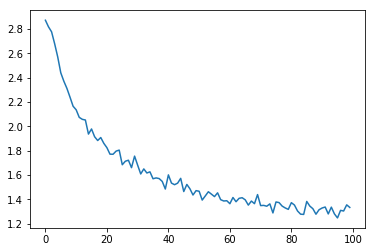

In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Predição

Agora que nossa rede neural foi treinada, vamos definir uma função de predição para que, dado um novo nome, a rede compute qual o idioma daquele nome:

In [10]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output


def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')
predict('Marques')
predict('Siqueira')
predict('Diego')
predict('Sakura')
predict('Júlio')


> Dovesky
(-0.79) Czech
(-1.22) Russian
(-2.31) English

> Jackson
(-0.20) Scottish
(-2.37) English
(-3.67) Russian

> Satoshi
(-0.83) Italian
(-2.24) Arabic
(-2.27) Japanese

> Marques
(-0.24) Portuguese
(-2.13) Spanish
(-3.22) French

> Siqueira
(-0.29) Portuguese
(-2.13) Spanish
(-3.15) Italian

> Diego
(-1.04) Spanish
(-1.10) Portuguese
(-2.60) Chinese

> Sakura
(-0.97) Japanese
(-1.68) Czech
(-1.88) Arabic

> Júlio
(-0.92) Korean
(-2.17) Italian
(-2.26) Scottish


## Próximos passos

* Endenter melhor porque apenas duas camadas
* Criar uma RNN similar para predizer nome -> gênero